## Overview

In order to answer a user's question, we need to accurately identify which table contains the relevant information. The first stage is to identify a set of candidate tables, based on the information in the table and the question. There is a parameter 'k' which determines how many tables are returned in the candidate set. Although recall will obviously improve with higher values of k, we typically want this first stage to identify a small candidate set, as a larger candidate set will result in a more expensive, less precise subsequent call to the LLM, when we try to filter the candidate set down to a single table.

## Metrics

Recall@k (R@k): we need to determine the recall for different values of k (which will inform the runtime choice of a suitable value for k). 
Note that if a system parameter like the value of k is chosen using data that will also be used to test the system as a whole, this invalidates that evaluation to some extent. In reality, a different dataset should be used to select a value for k.

## Conclusion

The results below clearly indicate diminishing returns for values of k ~ 60 and higher. Although it's impossible to properly identify a suitable value for k without understanding the downstream implications on cost and statistical accuracy, this does set an upper bound on the value of k.

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, module_path)

In [9]:
# read in the records
from tomoro.record import read_records

data_path = '../data/train.json'
all_records = read_records(data_path)
len(all_records)

3037

In [10]:
import random

# use a random sample of the records
records = random.sample(all_records, 200)
len(records)

200

In [11]:
from tomoro.utils import make_table_name

# the correct answer for the required table name is derived from the record id 
questions = []
expected_table_names = []

for record in records:
    table_name = make_table_name(record.id)
    qs = [qa.question for qa in record.qa]
    questions.extend(qs)
    expected_table_names.extend([table_name] * len(qs))

print(len(questions), len(expected_table_names))

252 252


In [21]:
from tomoro.vector_store import get_store
from tomoro.config import get_env_var
from tqdm import tqdm 

# for each question, we get the results for the max value of k, and then truncate during each evaluation step 
max_k = 100

store_type = get_env_var('VECTOR_STORE')
db_path = '../.vector_db'
collection_name = get_env_var('VECTOR_DB_COLLECTION_NAME')

vector_store = get_store(store_type, db_path=db_path, collection_name=collection_name)
results = []
for question in tqdm(questions):
    documents = vector_store.retrieve(question, k=max_k)
    table_names = [d.metadata['table_name'] for d in documents]
    results.append(table_names)
len(results)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 252/252 [02:04<00:00,  2.03it/s]


252

In [29]:
# now evaluate recall for different values of k
eval_results = []
for k in range(5, max_k + 5, 5):
    true_positives = 0
    false_negatives = 0
    for q_expected_name, q_results in zip(expected_table_names, results):
        # truncate the results to k
        k_results = set(q_results[:k])
        if q_expected_name in k_results:
            true_positives +=1
        else:
            false_negatives += 1
    recall_at_k = round(true_positives / (true_positives + false_negatives), 4)
    eval_results.append((k, recall_at_k, true_positives, false_negatives))


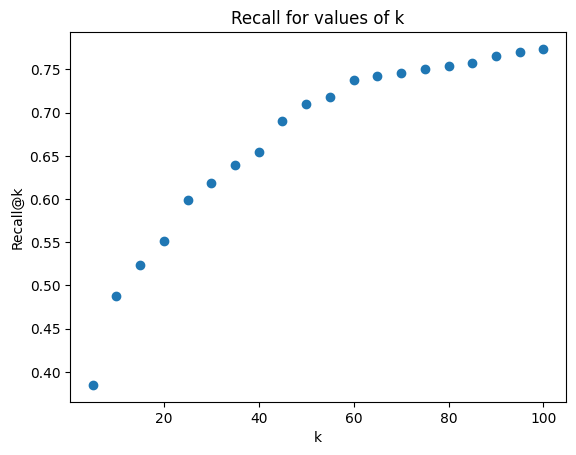

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(eval_results, columns=['k', 'recall@k', 'tp', 'fn'])
plt.title('Recall for values of k')
plt.xlabel('k')
plt.ylabel('Recall@k')
plt.scatter(x=df['k'], y=df['recall@k'])